# Model evaluation and optimization for text classification

Yesterday we learned the basics of training supervised machine learning models for text classification. Today we will learn more about how to evaluate models and how to optimize them for a specific case. This involves training more models and learning different and better ways to estimate their performance.

## Learning Goals
* Get comfortable with vocabulary of model evaluation and optimization
* Learn the basic mechanics of decision tree and random forest models
* Learn a few methods for model evaluation and how to implement
* Understand cross-validation and how to interpret
* Understand the basic rationale for model optimization
* Gain experience implementing, comparing, and optimizing machine learning models 

## Outline

* [Metrics for model evaluation](#metrics)
* [Load and inspect dataset](#dataset)
    * [Import modules](#import)
    * [Read and inspect data](#dataset)
    * [Preprocess data](#preprocess)
    * [Vectorization](#vectorize)
    * [Divide data into training and test sets](#split)
* [More classification with supervised machine learning](#supervised)
    * [Train decision tree model](#model)
    * [More model evaluation](#evaluate)
    * [Cross-validation](#cv)
    * [Optimize parameters with grid search](#gridsearch)
    * [Train and optimize Random Forest model](#RF)
    
## Key Terms

* *ground truth*:
    * The actual class of an object being classified. For instance, for sentiment analysis of social media, a tweet about joyful things verifiably belongs in the "happy" category.
* *predicted positives/negatives*:
    * All cases that are predicted as positive/negative by a supervised machine learning classifier
* *true positives/negatives*:
    * Cases that are correctly predicted as positive/negative by a classifier
* *condition positives/negatives*:
    * All positive/negative cases according to ground truth, regardless of classifier predictions
* *confusion matrix*:
    * Table layout of model performance, showing the relationships between predicted, true, and condition positives and negatives.
* *accuracy*:
    * The ratio of true positives and true negatives (the numerator) to the total number of cases (the denominator) in a machine learning task
* *precision*:
    * The ratio of true positives to predicted positives
* *recall*:
    * The ratio of true positives to condition positives
* *f1-score*:
    * The harmonic mean of precision and recall, this decreases with either metric more than would an arithmetic average
* *overfitting*:
    * When a model is trained on too little data to generalize to new data, usually when trained and tested on the same sample. In this case, the model just repeats the labels of the samples that it has just seen, and is evaluated to have a perfect score--but it fails to predict anything useful on yet-unseen data.
* *cross-validation*:
    * A way to assess the performance of an algorithm on an unseen data set. Essentially this repeats a train-test split several times and averages the result of these independent slices, giving a superior estimation of model accuracy compared to a single train-test split.
* *parameter*:
    * An algorithm setting that may be selected for performance or substantive reasons. If a parameter is not learned directly within an estimator but instead must be set explicitly (passed as an argument), then it's called a _hyper-parameter_.
* *grid-search*:
    * An exhaustive search over model parameters to discover the configuration that maximizes model performance

# Metrics for model evaluation<a id='metrics'></a>

Model accuracy is one of the most common and useful metrics for model evaluation. Accuracy can be defined as:

$$Accuracy= \frac{\sum{\text{True Positives}}+\sum{\text{True Negatives}}}{\sum{\text{Total Population}}}$$

Where "True Positives" are those data points whose ground truth value is 1, and they are predicted to be 1; and "True Negatives" are those data points whose ground truth value is -1 (or 0), and they are predicted to be -1 (or 0).

In other words, a model's accuracy is the ratio of overall correct guesses (either positive or negative) to the total number of cases. To compute this metric, we compare the set of predicted labels (the labels the algorithms assigned to the test set) to the true labels for the test set. More technically, for binary and multiclass classification (which is all we're doing), the `accuracy_score` function in `scikit-learn` calculates the size of the intersection divided by the size of the union of two label sets--which is called the "Jaccard similarity coefficient". 

However, there are other metrics for evaluating models than just accuracy. The other metrics include: 

1. **Precision**: 
$$\frac{\sum{\text{True Positives}}}{\sum{\text{Predicted Positives}}}$$
2. **Recall** (or **Sensitivity**): 
$$\frac{\sum{\text{True Positives}}}{\sum{\text{Condition Positives}}}$$ 
3. **Specificity** (like recall for negative examples): 
$$\frac{\sum{\text{True Negatives}}}{\sum{\text{Condition Negatives}}}$$

This visual shows how precision and recall are calculated relative to true positives and negatives (the left and right halves, respectively) and predicted positives (the inner circle): 

<img src='../assets/precision_recall.svg' width=400 />

Consider these two questions when deciding which model evaluation metric(s) to use when applying machine learning:
- Are you interested in the proportion of correct positive AND negative predictions, or just one of the two? 
- Do you want to maximize correct guesses (i.e., fewer false positives) or model coverage (i.e., fewer false negatives)? **Precision** represents the former while **recall** indicates the latter. 

For example, if we train a classifier to identify happy tweets in particular, correctly predicting negative cases is less important (since identifying the not-happy ones is not our goal) and we can focus on just the correct positive predictions. This would be a good case for using the **recall** metric. On the other hand, if we train a model to differentiate spam emails from not-spam emails, both positive and negative predictions are relevant, because we want a classifier that can predict both of these types successfully. Then we would use **precision**. In that case we might also use the F1-score, which is the harmonic mean of precision and recall (this means it decreases with either metric more than would an arithmetic average) and like accuracy is useful in lots of situations.

# Data preparation<a id='preparation'></a>

## Import modules<a id='import'></a>

In [76]:
import os
import re
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

#scikit-learn is a huge library. We import what we need.
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, train_test_split #sklearn utilities
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report #For model evaluation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer #Vectorizers
from sklearn.linear_model import LogisticRegressionCV #Logit with cross-validation
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier #Random Forest and AdaBoost classifiers
from sklearn.tree import DecisionTreeClassifier #Decision Tree classifier
from sklearn.svm import LinearSVC #Linear Support Vector classifier

## Read and inspect dataset<a id='dataset'></a>

The dataset was collected by [Crowdflower](https://www.crowdflower.com/), which they then made public through [Kaggle](https://www.kaggle.com/crowdflower/twitter-airline-sentiment). Note that this is a nice clean dataset--not the norm in real-life data science, but it lets us focus on text classification rather than preprocessing.

In [2]:
df = pd.read_csv('tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Which airlines are tweeted about and how many of each in this dataset?

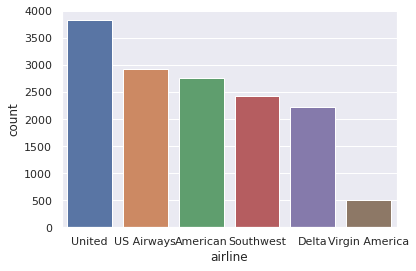

In [3]:
sns.countplot(df['airline'], order=df['airline'].value_counts().index)

### Challenge

- How many tweets are in the dataset?
- How many tweets are positive, neutral and negative?
- What **proportion** of tweets are positive, neutral and negative?
- Visualize these last two questions. 
- What are the three main reasons why people are tweeting negatively? 

_Hint:_ To visualize counts, you can use the `sns.countplot()` function. To visualize proportions, use the `.plot(kind='bar')` method.

In [ ]:
# your code here

In [4]:
# solutions
print("Length is", len(df))

df['airline_sentiment'].value_counts()

Length is 14640


negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [5]:
df['airline_sentiment'].value_counts(normalize=True)

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

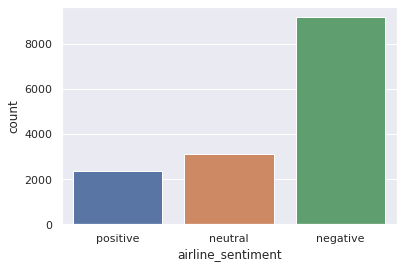

In [6]:
sns.countplot(df['airline_sentiment'], order=['positive', 'neutral', 'negative'])

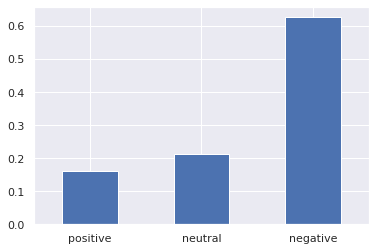

In [7]:
df['airline_sentiment'].value_counts(normalize=True, ascending=True).plot(kind='bar', rot=0)

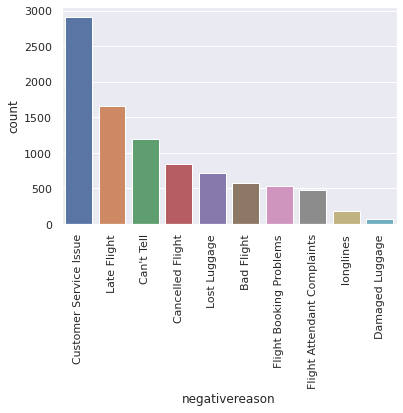

In [12]:
sns.countplot(df['negativereason'], order=df['negativereason'].value_counts().index)
plt.xticks(rotation=90);

## Preprocess data<a id='preprocess'></a>

How are we going to turn our tweets into numbers? First, let's do some quick preprocessing to remove usernames, hashtags, and URLs. Let's assume we don't need any of this information, so removing such junk will sharpen the signal of the text itself.

In [23]:
twitter_handle_pattern = r'@(\w+)'
hashtag_pattern = r'(?:^|\s)[＃#]{1}(\w+)'
url_pattern = r'https?:\/\/.*.com'

my_tweets = ["lol @justinbeiber and @BillGates are like soo #yesterday #amiright saw it on https://twitter.com #yolo",
            'omg I am never flying on Delta again',
            'I love @VirginAmerica so much #friendlystaff']

# Simplest way to clean this up is with string methods:
for tweet in my_tweets:
    print(tweet.replace(hashtag_pattern, 'HASHTAG')
          .replace(twitter_handle_pattern, 'USER')
          .replace(url_pattern, 'URL')
         )

lol @justinbeiber and @BillGates are like soo #yesterday #amiright saw it on https://twitter.com #yolo
omg I am never flying on Delta again
I love @VirginAmerica so much #friendlystaff


### Challenge

1. Create a function called `clean_tweet()` that takes in a tweet text; replaces hashtags, users, and URLs; and returns the result. 
2. Test it out on the `my_tweets` list object just defined: the output should be the same as that of the string methods we just used!
3. Apply the `clean_tweet()` function to the tweets dataframe above to create a new `clean_text` column.

_Hint:_ Use the handy `re.sub()` method for pattern replacement and `df[col].apply()` for applying a function to a specific DataFrame column.

In [ ]:
# your code here

In [20]:
# solution
def clean_tweet(tweet):
    tweet = re.sub(hashtag_pattern, ' HASHTAG', tweet) 
    tweet = re.sub(twitter_handle_pattern, 'USER', tweet)
    return re.sub(url_pattern, 'URL', tweet)

[clean_tweet(tweet) for tweet in my_tweets]

['lol USER and USER are like soo HASHTAG HASHTAG saw it on URL HASHTAG',
 'omg I am never flying on Delta again',
 'I love USER so much HASHTAG']

In [21]:
# apply function to DF 
df['clean_text'] = (df['text'].apply(clean_tweet))
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,clean_text
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),USER What USER said.
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),USER plus you've added commercials to the expe...
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),USER I didn't today... Must mean I need to tak...
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),USER it's really aggressive to blast obnoxious...
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),USER and it's a really big bad thing about it


## Vectorization<a id='vectorization'></a>

Now that we've cleaned the text, we turn the text into numbers for our classifier. As we did yesterday, we will use `scikit-learn`'s `CountVectorizer` and a "bag of words" approach to create our features: frequency counts of all the words that appear in a text. 

In [28]:
countvectorizer = CountVectorizer(max_features=5000, binary=True)
X = countvectorizer.fit_transform(df['clean_text'])
features = X.toarray() # convert matrix to sparse format for easy modeling
features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [29]:
response = df['airline_sentiment'].values # corresponds to entries in `features` 
response

array(['neutral', 'positive', 'neutral', ..., 'neutral', 'negative',
       'neutral'], dtype=object)

## Divide data into training and test sets<a id='split'></a>

As we did yesterday, let's split our data into training and test sets. _Unlike_ yesterday, we will use a shortcut to create this split: the useful `train_test_split()` function from `scikit-learn`. We will also balance the outcome variable (sentiment) between our training and test samples. 

We'll train on 80% of the data and test the model's accuracy on the rest. An 80/20 split is typical in machine learning tasks; according to the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle), this ratio allows for efficiency and occurs in nature as well as in business, computing, and economics. 

In [30]:
X_train, X_test, y_train, y_test = train_test_split(features, response, test_size=0.2)

X_train.shape, X_test.shape #look at number of rows and columns in training and test data

((11712, 5000), (2928, 5000))

Now that we've split our data up into `train` and `test` sets, let's look to see how the output variable is distributed within the two datasets.

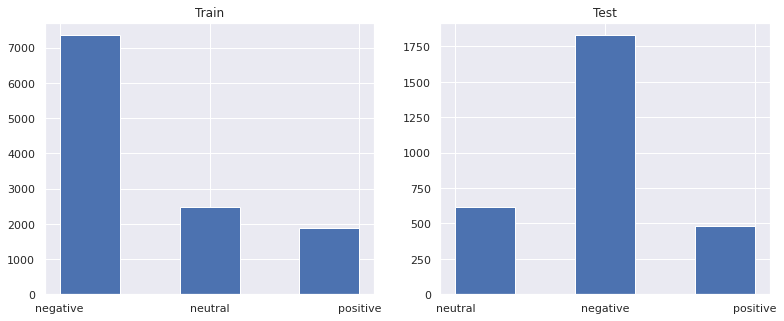

In [40]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1) # shows separate plot on left 
plt.hist(y_train, bins=5)
plt.title('Train')

plt.subplot(1,2,2) # shows separate plot on right
plt.hist(y_test, bins=5);
plt.title('Test');

The three possible values of the output variable (sentiment) appear more or less equally distributed across the training and test datasets, which matters for model performance. (If they weren't, we could use the `stratify` parameter of `sklearn` to split them equally.)

# More classification with supervised machine learning<a id='supervised'></a>

## Train decision tree model<a id='model'></a>

Now that we've turned our data into numbers, we're ready to feed it into another classifier: this time a common type called [decision trees](http://scikit-learn.org/stable/modules/tree.html#classification). 

### TO DO: Describe how this model works

In [42]:
dt_classifier = DecisionTreeClassifier(criterion='gini',  # or 'entropy' for information gain
                                       splitter='best',  # or 'random' for random best split
                                       max_depth=None,  # how deep tree nodes can go
                                       min_samples_split=2,  # samples needed to split node
                                       min_samples_leaf=1,  # samples needed for a leaf
                                       min_weight_fraction_leaf=0.0,  # weight of samples needed for a node
                                       max_features=None,  # number of features to look for when splitting
                                       max_leaf_nodes=None,  # max nodes
                                       min_impurity_decrease=1e-07, #early stopping
                                       random_state = 10) #random seed

dt_classifier.fit(X_train, y_train) # fit model on training set

DecisionTreeClassifier(min_impurity_decrease=1e-07, random_state=10)

To test model performance, we can use either `accuracy_score()` or the built-in `score` method to return the mean accuracy. Either method can be used on both the train and test datasets. Let's check the in-sample accuracy of the model on the training data:

In [126]:
#predict the labels on the test set using the trained model
predictions_dt = dt_classifier.predict(X_train) 

accuracy_score(predictions_dt, y_train)

0.9962431693989071

That's an excellent score! Unfortunately, it results from overfitting--using the same data for model training as for evaluation. To get a better sense of how our model would generalize to unseen data, let's evaluate the performance of this model using the test data:

In [62]:
# Let's use the built-in `model.score()` method instead this time, results are same as for `accuracy_score()`
print(dt_classifier.score(X_test, y_test))

0.7025273224043715


Not quite perfect, but more realistic and still good!

### Challenge

A common practice in machine learning is to quickly try a bunch of algorithms, see which one works the best, and optimize it. In this spirit...

**Part 1**

Apply these two additional algorithms without bothering to learn how they work: 
- Linear Support Vector Classification (`LinearSVC()`) and 
- Logistic Regression with cross-validation (`LogisticRegressionCV()`; more on cross-validation below).
    
Train each of these on the training set and evaluate accuracy on the test set.

In [ ]:
# your code here

In [96]:
# solution
svc = LinearSVC()
svc.fit(X_train, y_train)
predictions_svc = svc.predict(X_test) 
accuracy_score(predictions_svc, y_test)

0.7711748633879781

In [97]:
logitcv = LogisticRegressionCV(Cs=5, 
                               penalty='l1', 
                               cv=3, 
                               solver='liblinear', 
                               refit=True)

logitcv.fit(X_train, y_train)
predictions_logitcv = logitcv.predict(X_test) 
accuracy_score(predictions_logitcv, y_test)

0.8015710382513661

**Part 2**

Use the logistic regression classifier you just trained to predict the label for three unlabeled reviews. Predict both the label and the probability of being in each category. Do the predictions make sense? Do the probabilities provide any useful information beyond the predicted labels?

_Hint:_ Remember to use `countvectorizer()` and convert to sparse format with `.toarray()` to vectorize the texts prior to prediction. Use `model.predict()` to predict the class and `model.predict_proba()` to predict class probabilities.

In [98]:
careless_review = "I made my flight reservation with UnitedAirlines and the service is ridiculous and they just bluntly \
deny solving your problem. I booked my flight but they were having some technical issues and didn't appear \
in their system. United customer service just said they can not do anything and asked me to book a new ticket to fly. \
This is just insane and troubling and also really costly at the airport. Thus, I made my flight reservation \
with United Airlines for the next day through an online flight booking portal that offered much cheaper flights. \
You can contact them over the phone by calling a toll-free number +1-888-720-1433 and book flights that are light \
on your pocket."

good_review = "United was very accommodating for our vacation recently and even got us home a little quicker. \
We were travelling in a group of 12 coming home from a vacation and because of storms back east our connecting flight \
was delayed by hours. Knowing this was completely out of their control we started talking with one of the United \
employees and told them where we were headed. She said she could get us on a flight that actually leaves earlier \
than our original flight. It was such great service and resulted in all of us getting home hours later. The only \
issue was our bags, but United had them delivered to our homes that next morning."

canceled_review = "Canceled my trip twice, the first time I received no notification. The second time I got a notice \
that one of my trips may have been canceled or changed, the website didn’t say which it was. It instructed me to cancel \
it myself. Probably so they could avoid having to refund me. Now I all the money I spent on tickets sitting in a United \
account but I never want to fly with them in the future so that’s a nice chunk of about $2000 wasted. \
EDIT: After I cancelled my second trip I was able to select an option for refund, the refund was not only \
for the second trip but also my first trip that was cancelled earlier. I will upgrade the rating from 1 to 3 stars \
would have given higher with better customer service/website service/website information."

In [ ]:
# your code here

In [124]:
# solution
# Transform these into DTMs with the same feature-columns as previously
unknown_dtm = countvectorizer.transform([careless_review, good_review, canceled_review]).toarray()

# Use model to predict the class for these three. Predict class
print("Predicted classes:")
print(logitcv.predict(unknown_dtm))
print()
print(f"Predicted probabilities for each review\n(order: {logitcv.classes_}):")
print(logitcv.predict_proba(unknown_dtm)) # Predict probability of membership in each category

Predicted classes:
['negative' 'negative' 'negative']

Predicted probabilities for each review
(order: ['negative' 'neutral' 'positive']):
[[9.99946666e-01 1.03044648e-06 5.23034636e-05]
 [9.87913151e-01 9.94473654e-08 1.20867500e-02]
 [9.99995052e-01 7.31622676e-07 4.21680542e-06]]


## Cross-validation<a id='cv'></a>

Dividing our labeled data into a single set of training and test data gives a limited picture of how our algorithm performs on unseen data. Ideally, we would want a lot of unseen data to test our model on, to reduce the risk that the test data we selected (even if randomly) is unusually similar to or different from the training data in terms of structure. How can we use our limited labeled data to get a better sense of the accuracy of a trained model? 

This is where **cross-validation** comes in. Usually this refers to _k_-fold cross-validation, which instead of building a model from the training data in one swoop, splits the training data into _k_ smaller sets or "folds", trains separate models, and averages the result. In other words, the procedure for _k_-fold cross-validation (as described in the [scikit-learn documentation](https://scikit-learn.org/stable/modules/cross_validation.html)) is:

- A model is trained using $k-1$ of the folds as training data;
- the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).

This visual shows what these splits look like in terms of model training (this is what "finding parameters" means, we'll discuss this more in a moment):

<img src='../assets/cross_validation.png' width=700/>

Cross-validation can be easily implemented using `scikit-learn`'s `cross_val_score()` function:

In [58]:
scores = cross_val_score(dt_classifier, X_train, y_train, cv=5)
scores   

array([0.68245839, 0.6978233 , 0.68915457, 0.69513237, 0.676345  ])

In [68]:
# Show average accuracy across folds along with sigma (std. squared)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.6882 (+/- 0.0159)


### Challenge

Why is the cross validation accuracy different than our classifier? Which estimate is more accurate?

This assumes any unseen data has similar features as your training and test data. If the features are different, you can not assume you will get similar accuracy. When might the unseen data be different from the labeled data?

## More model evaluation <a id="evaluate"></a>

One of the most useful layouts to observe model performance is a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix), a table layout showing the relationships between predicted, true, and condition positives and negatives. Columns show predicted outcomes, while rows show ground truth. First let's look at the raw output of `scikit-learn`'s `confusion_matrix()` method.

In [130]:
confusion_matrix(y_test, dt_classifier.predict(X_test))

array([[1496,  242,   90],
       [ 246,  305,   67],
       [ 140,   86,  256]])

This is a little hard to interpret, so let's make a prettier table to show model performance on the test set.

Text(0.5, 12.5, 'Prediction')

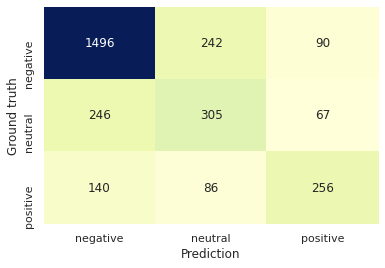

In [131]:
model = dt_classifier # change this one line to visualize confusion matrix for other models
y_predict = model.predict(X_test) 
labels = model.classes_
conmat = confusion_matrix(y_test, y_predict)

sns.heatmap(conmat, 
            annot=True, 
            fmt='d', 
            xticklabels=labels, 
            yticklabels=labels, 
            cmap="YlGnBu", 
            cbar=False)
plt.ylabel('Ground truth')
plt.xlabel('Prediction')

That's better, but what about the different metrics to convey all this information? Above we looked at accuracy, but `scikit-learn` can also print out a lot more information--including the **precision** and **recall** scores for each outcome--of a classification model with the `classification_report()` method.

In [50]:
dt_predicted = dt_classifier.predict(X_test)
print("Classification report:")
print(classification_report(y_test, dt_predicted)) 

Classification report:
              precision    recall  f1-score   support

    negative       0.79      0.82      0.81      1828
     neutral       0.48      0.49      0.49       618
    positive       0.62      0.53      0.57       482

    accuracy                           0.70      2928
   macro avg       0.63      0.61      0.62      2928
weighted avg       0.70      0.70      0.70      2928



## Optimize parameters with grid search <a id="gridsearch"></a>

Optimizing model parameters is one of the most important steps in building a supervised machine learning model. One way to do this is by using what's called a [grid search](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). A grid search tests different possible parameter combinations to see which combination yields the most accurate predictions. Fortunately, `scikit-learn` makes this very easy to do with the `GridSearchCV()` function. 

Here we'll see what is the best combination of the parameters `min_samples_split` and `min_samples_leaf` for building a decision tree model to predict user sentiment in our airline reviews dataset. We can make a dictionary with the names of the parameters as the keys and the range of values as the corresponding values.

In [84]:
# Grid searching is computationally expensive, so for time's sake we'll test a minimal range for each parameter
# In real-world data analytics there would be a much larger range, making exponentially more permutations (and time cost)

param_grid = {'min_samples_split': [2,10], # define dictionary with possible model parameters
              'min_samples_leaf': [2,10]}

param_grid

{'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 5, 10]}

Then we can implement the grid search and fit our model according to the best parameters.

In [85]:
# Warning: This can take a long time!
model_dt = GridSearchCV(dt_classifier(), 
                        param_grid, 
                        cv=3, 
                        return_train_score=True)

model_dt.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(min_impurity_decrease=1e-07,
                                              random_state=10),
             iid=False,
             param_grid={'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 6, 10]},
             return_train_score=True)

To see what are the model parameters to produce the highest accuracy on the training set, we will find the maximum `mean_train_score` and its associated parameter values:

In [ ]:
# Get information on model parameters that perform best
model = model_dt # Change this to visualize other models

# Get index of best model parameters
best_index = np.argmax(
    model.cv_results_["mean_train_score"]
                      )

print('Best parameter values are:', 
      model.cv_results_["params"][best_index]
     )
print('Best mean cross-validation train accuracy: %.03f' % 
      model.cv_results_["mean_train_score"][best_index]
     )
print('Best mean cross-validation test (validation) accuracy: %.03f' % 
      model.cv_results_["mean_train_score"][best_index]
     )
print('Overall mean test accuracy: %.03f' % 
      model.score(X_test, y_test)
     )

We can also look at all of the combinations and their test and train scores using 3-d visualization:

In [87]:
# Prepare for visualization: get combinations on tested model parameters
n_grid_points = len(model_dt.cv_results_['params'])
min_samples_leaf_vals = np.empty((n_grid_points,))
min_samples_split_vals = np.empty((n_grid_points,))
mean_train_scores = np.empty((n_grid_points,))
mean_test_scores = np.empty((n_grid_points,))

for i in range(n_grid_points):
    min_samples_leaf_vals[i] = model.cv_results_['params'][i]['min_samples_leaf']
    min_samples_split_vals[i] = model.cv_results_['params'][i]['min_samples_split']
    mean_train_scores[i] = model.cv_results_['mean_train_score'][i]
    mean_test_scores[i] = model.cv_results_['mean_test_score'][i]

In [132]:
def gridsearch_viz(mean_scores, 
                   param1_vals, 
                   param2_vals, 
                   param1_name, 
                   param2_name, 
                   scorename = "Mean Scores"):
    """Build 3-d visualization to show model parameter combinations and their resulting scores.
    
    Args:
        mean_scores: List of model scores, as long as list of model parameters being tested.
        param1_vals: list of values for first parameter, as long as list of model parameters being tested.
        param2_vals: list of values for second parameter, as long as list of model parameters being tested.
        param1_name: str indicating name of first parameter being tested
        param2_name: str indicating name of second parameter being tested
        scorename: str indicating name of scores being displayed (train or test).
        
    Output:
        3-d visualization of model params & performance
        """

    # Visualize model performance on training set
    fig = plt.figure(figsize=(20,10))
    ax = fig.gca(projection='3d')

    surf = ax.plot_trisurf(param1_vals, 
                           param2_vals, 
                           mean_scores, 
                           cmap=cm.coolwarm,
                           linewidth=10, 
                           antialiased=False)

    ax.set_title(scorename, fontsize=18)
    ax.set_xlabel('param1_name', fontsize=18)
    ax.set_ylabel('param2_name', fontsize=18)

Text(0.5, 0, 'min_samples_split')

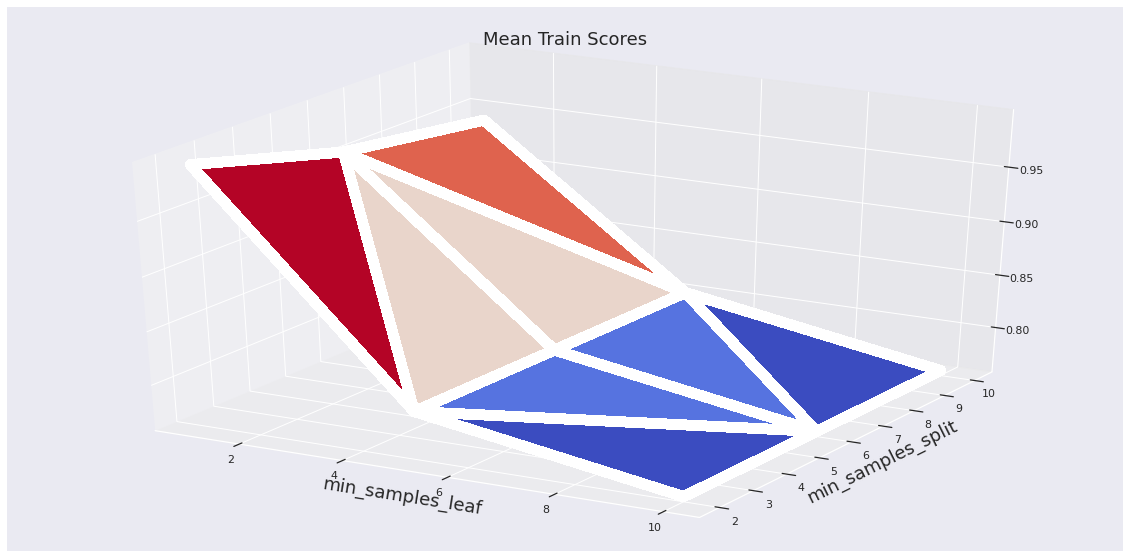

In [88]:
# Visualize model performance on training set
gridsearch_viz(mean_scores = mean_train_scores, 
               param1_vals = min_samples_leaf_vals, 
               param2_vals = min_samples_split_vals, 
               param1_name = "min_samples_split", 
               param2_name = "min_samples_leaf", 
               scorename = "Mean Train Scores")

Text(0.5, 0, 'min_samples_split')

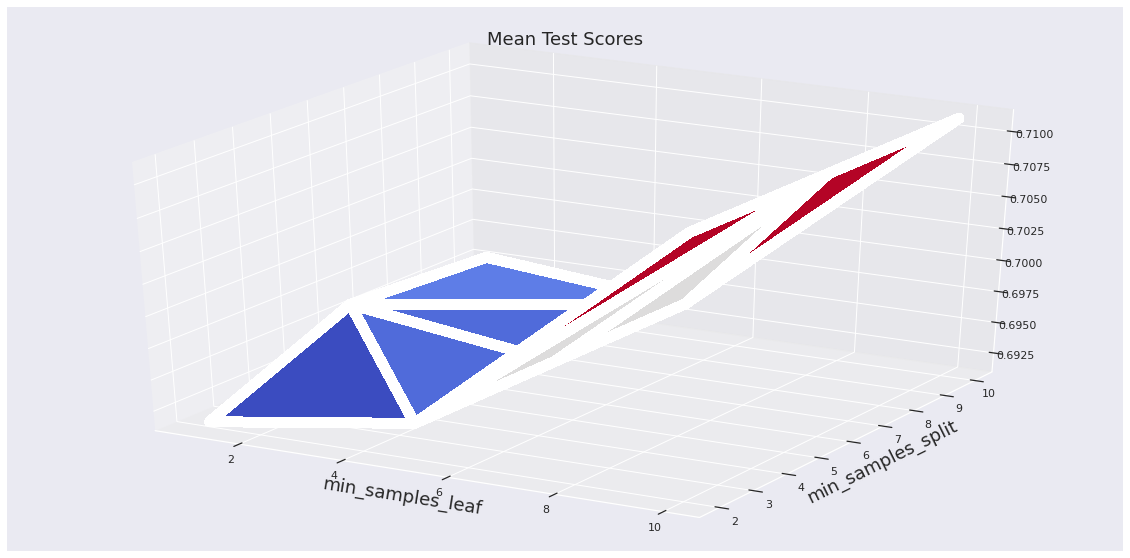

In [89]:
# Visualize model performance on test set
gridsearch_viz(mean_scores = mean_test_scores, 
               param1_vals = min_samples_leaf_vals, 
               param2_vals = min_samples_split_vals, 
               param1_name = "min_samples_split", 
               param2_name = "min_samples_leaf", 
               scorename = "Mean Test Scores")

## Train and optimize Random Forest model <a id="RF"></a>

Now we'll look at [Random Forests](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

- random forests are an ensemble method (the classification decision is pooled across many simpler classifiers)
- each decision tree is fit to a subset of the data (bagging), and uses only a subset of the features (random subspace). 

### TO DO: Describe how this model works

In [90]:
rf_classifier = RandomForestClassifier(n_estimators=10,  # number of trees
                       criterion='gini',  # or 'entropy' for information gain
                       max_depth=None,  # how deep tree nodes can go
                       min_samples_split=2,  # samples needed to split node
                       min_samples_leaf=1,  # samples needed for a leaf
                       min_weight_fraction_leaf=0.0,  # weight of samples needed for a node
                       max_features='auto',  # number of features for best split
                       max_leaf_nodes=None,  # max nodes
                       min_impurity_decrease=1e-07,  # early stopping
                       n_jobs=1,  # CPUs to use
                       random_state = 10,  # random seed
                       class_weight="balanced")  # adjusts weights inverse of freq, also "balanced_subsample" or None

Now we fit the model on our training data.

In [91]:
rf_model = rf_classifier.fit(X_train, y_train)

Let's look at the classification performance on the test data:

In [136]:
print("Accuracy of Random Forest model (with 5-fold CV) with test data defined above:")
scores = cross_val_score(rf_model, X_test, y_test, cv=5)
print("%0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2)) # Show average accuracy across folds
print()

predicted = rf_model.predict(X_test)
print("Classification report:")
print(classification_report(y_test, predicted)) 
print()

Accuracy of Random Forest model (with 5-fold CV) with test data defined above:
0.7025 (+/- 0.0236)

Classification report:
              precision    recall  f1-score   support

    negative       0.74      0.97      0.84      1828
     neutral       0.70      0.33      0.44       618
    positive       0.77      0.40      0.53       482

    accuracy                           0.74      2928
   macro avg       0.74      0.56      0.60      2928
weighted avg       0.74      0.74      0.70      2928




### Challenge: Grid Search on Random Forest

Do another grid search to determine the best parameters for the Random Forest we just created. Use two possible levels for `min_samples_split` and `min_samples_leaf`, each between 1 and 10. 

In [ ]:
# your code here

In [ ]:
# solution
param_grid = {'min_samples_split': [2,10],
              'min_samples_leaf': [2,10]}

rf_model = GridSearchCV(RandomForestClassifier(n_estimators=10, 
                                               min_impurity_decrease=1e-07,  # early stopping
                                               random_state = 10,  # random seed
                                               class_weight="balanced_subsample"), # adjusts weights inverse of freq with subsampling
                        param_grid, 
                        cv=3)

rf_model.fit(X_train, y_train)

In [93]:
best_index = np.argmax(rf_model.cv_results_["mean_train_score"])

print("Best parameter values:", rf_model.cv_results_["params"][best_index])
print("Best mean cross-validated training accuracy:", rf_model.cv_results_["mean_train_score"][best_index])
print("Overall mean test accuracy:", rf_model.score(X_test, y_test))

Best parameter values: {'min_samples_leaf': 2, 'min_samples_split': 2}
Best Mean cross-validated test accuracy: 0.732667349726776
Overall Mean test accuracy: 0.7394125683060109


### Extra challenge: Adjust text preprocessing

Preprocessing methods matter for machine learning performance: Depending on the algorithm, less or more preprocessing may be better. Let's see how a simple Random Forest model does with minimal preprocessing--without removing usernames, hashtags, or URLs. Compare this model's performance with that of Random Forest trained on cleaned text.

In [ ]:
# your code here

In [133]:
# solution
# Vectorize texts
countvec_dirty = CountVectorizer(max_features=5000, binary=True)
features_dirty = countvec_dirty.fit_transform(df['text']).toarray() # convert matrix to sparse format for easy modeling
response_dirty = df['airline_sentiment'].values # corresponds to entries in `features` 

X_train_dirty, X_test_dirty, y_train_dirty, y_test_dirty = train_test_split(features_dirty, response_dirty, test_size=0.2)
X_train_dirty.shape, X_test_dirty.shape #look at number of rows and columns in training and test data

((11712, 5000), (2928, 5000))

In [134]:
rf_dirty = RandomForestClassifier(n_estimators=10,  # number of trees
                                  min_impurity_decrease=1e-07,  # early stopping
                                  random_state = 10,  # random seed
                                  class_weight="balanced")  # adjusts weights inverse of freq

rf_dirty = rf_dirty.fit(X_train_dirty, y_train_dirty)

In [135]:
scores = cross_val_score(rf_dirty, X_train_dirty, y_train_dirty, cv=5)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2)) # Show average accuracy across folds
print("Overall mean test accuracy:", rf_dirty.score(X_test_dirty, y_test_dirty))

Accuracy: 0.7423 (+/- 0.0110)
Overall mean test accuracy: 0.7469262295081968


Random Forest with text preprocessing gave a mean accuracy of 0.7025 (+/- 0.0236). So in this case, less text preprocessing improves model performance by about **4.4%**! 

### Extra extra challenge: Adaboost

Adaboost is another ensemble method that relies on 'boosting'. Similar to 'bagging', 'boosting' samples many subsets of data to fit multiple classifiers, but resamples preferentially for misclassified data points. 

**Part 1**

Using the scikit-learn [documentation](http://scikit-learn.org/stable/modules/ensemble.html#adaboost), build your own AdaBoost model to test on our review tweets! Start off with `n_estimators` at 100, and `learning_rate` at .5. Use 10 as the `random_state` value.

In [ ]:
# your code here

In [94]:
# solution
adaboost_model = AdaBoostClassifier(n_estimators=100,  # number of trees
                                         learning_rate=0.5,  # or 'entropy' for information gain
                                         random_state = 10)  # random seed

adaboost_model = adaboost_model.fit(X_train, y_train)

print("Score of Adaboost model with test data defined above:")
print(adaboost_model.score(X_test, y_test))
print()

predicted = adaboost_model.predict(X_test)
print("Classification report:")
print(classification_report(y_test, predicted)) 
print()

Score of Adaboost model with test data defined above:
0.7257513661202186

Classification report:
              precision    recall  f1-score   support

    negative       0.74      0.95      0.83      1828
     neutral       0.63      0.23      0.34       618
    positive       0.73      0.51      0.60       482

    accuracy                           0.73      2928
   macro avg       0.70      0.56      0.59      2928
weighted avg       0.71      0.73      0.69      2928




**Part 2**

Now use a grid search to determine what the best values for the `n_estimators` and `learning_rate` parameters are. For `n_estimators` try a range of 100 to 500 with a step of 100, and for `learning_rate` try a range of .1 to 1.0 with a step of .3. For decimal steps in a range use the `np.arange` function.

In [ ]:
# your code here

In [ ]:
# solution
param_grid = {'n_estimators': [100,500],
              'learning_rate': [0.1,1.0]}

adaboost_model = GridSearchCV(AdaBoostClassifier(n_estimators=10), 
                              param_grid, 
                              cv=3)
adaboost_model.fit(X_train, y_train)

# Get index on model parameters that perform best
best_index = np.argmax(adaboost_model.cv_results_["mean_train_score"]) # Get index of best model parameters

# Display information on best model parameters
print("Best parameter values:", adaboost_model.cv_results_["params"][best_index])
print("Best mean cross-validated train accuracy:", adaboost_model.cv_results_["mean_train_score"][best_index])
print("Overall mean test accuracy:", adaboost_model.score(X_test, y_test))

**Part 3**

Build a 3-d visualization showing combinations of model parameters and their resulting performance. 

_Hint:_ Use the `gridsearch_viz()` function we defined earlier.

In [ ]:
# your code here

In [87]:
model = adaboost_model # Change this to visualize other models

# Prepare for visualization: get combinations on tested model parameters
n_grid_points = len(model.cv_results_['params'])
min_samples_leaf_vals = np.empty((n_grid_points,))
min_samples_split_vals = np.empty((n_grid_points,))
mean_train_scores = np.empty((n_grid_points,))
mean_test_scores = np.empty((n_grid_points,))

for i in range(n_grid_points):
    n_estimators_leaf_vals[i] = model.cv_results_['params'][i]['min_samples_leaf']
    learning_rate_split_vals[i] = model.cv_results_['params'][i]['min_samples_split']
    mean_train_scores[i] = model.cv_results_['mean_train_score'][i]
    mean_test_scores[i] = model.cv_results_['mean_test_score'][i]

Text(0.5, 0, 'min_samples_split')

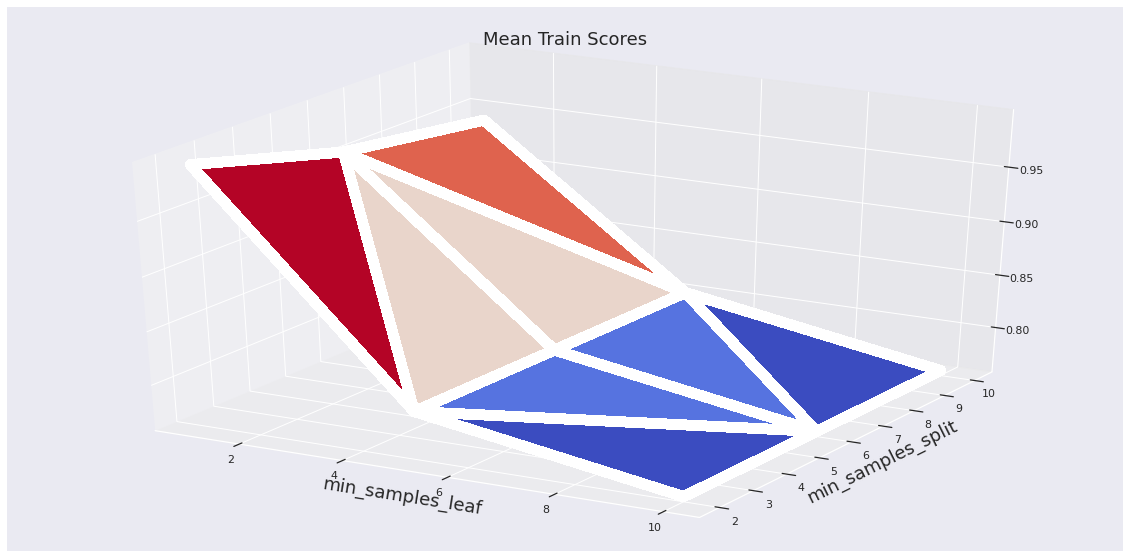

In [88]:
# solution
# Visualize model performance on training set
gridsearch_viz(mean_scores = mean_train_scores, 
               param1_vals = n_estimators_leaf_vals, 
               param2_vals = learning_rate_split_vals, 
               param1_name = "n_estimators", 
               param2_name = "learning_rate", 
               scorename = "Mean Train Scores")

Text(0.5, 0, 'min_samples_split')

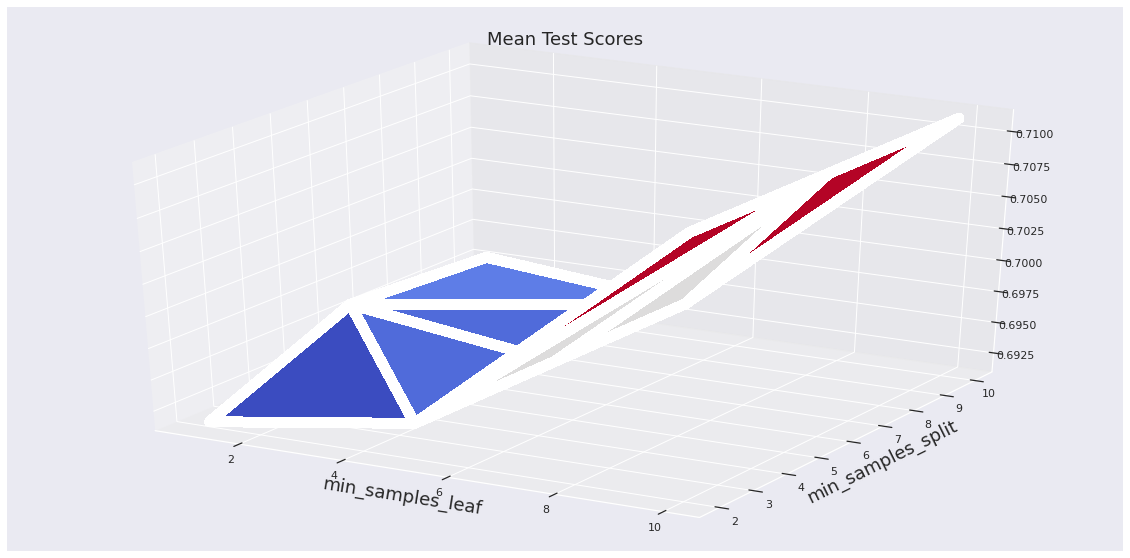

In [89]:
# Visualize model performance on test set
gridsearch_viz(mean_scores = mean_test_scores, 
               param1_vals = n_estimators_leaf_vals, 
               param2_vals = learning_rate_split_vals, 
               param1_name = "n_estimators", 
               param2_name = "learning_rate", 
               scorename = "Mean Test Scores")